In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from seaborn import pointplot
from keras.models import model_from_yaml
from librosa.display import specshow
from IPython.display import Audio


sys.path.append('/home/ci411/pcen-t-varying/')

import pcen_t.eval
from pcen_t.utils import *
from pcen_t.models import SqueezeLayer


URBANSED_CLASSES = ['air_conditioner',
                    'car_horn',
                    'children_playing',
                    'dog_bark',
                    'drilling',
                    'engine_idling',
                    'gun_shot',
                    'jackhammer',
                    'siren',
                    'street_music']

Using TensorFlow backend.
/home/ci411/pcen-t-varying/pcen_t/eval.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
slices_single = [str(i) for i in range(10)]
slices_multiple = [''.join(str(j) for j in np.arange(i+1)) for i in range(10)]
slices_midout = [''.join(str(j) for j in np.arange(n, 10-n)) for n in range(4,-1,-1)]
slices_midout.insert(0, '5')

real_reverb_set = ['bedroom','tunnel','alley']
sim_reverb_set = ['short','medium','long']

In [3]:
sample_df = pd.read_csv('sampled_results.csv', index_col=0)
sample_df['slices'] = sample_df['version'].map(lambda x : str(x.split('_')[1]))
sample_df['modelset'] = sample_df['version'].map(lambda x : str(x.split('_')[2]))

/scratch/ci411/.conda/envs/py3.8/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
sample_df['num_slices'] = sample_df['slices'].apply(lambda x : len(str(x)))

mel_rows = sample_df['slices'] == 'mel'
sample_df.loc[sample_df['slices'] == 'mel','num_slices'] = 0
sample_df

,version,training_set,slices,eval_dataset,model,class/metric,value,metric,class,modelset,num_slices
0,realreverb_7_1014,realreverb,7,bedroom,cnn_l3_strong,overall_p,0.666208,precision,overall,1014,1
1,realreverb_7_1014,realreverb,7,short,cnn_l3_strong,overall_p,0.302970,precision,overall,1014,1
2,realreverb_7_1014,realreverb,7,short,cnn_l3_strong,overall_p,0.344744,precision,overall,1014,1
3,realreverb_7_1014,realreverb,7,wet,cnn_l3_strong,overall_p,0.491612,precision,overall,1014,1
4,realreverb_7_1014,realreverb,7,medium,cnn_l3_strong,overall_p,0.281587,precision,overall,1014,1
...,...,...,...,...,...,...,...,...,...,...,...
3379195,realreverb_3456_1014,realreverb,3456,tunnel,cnn_l3_strong,street_music_e,1.029070,error_rate,street_music,1014,4
3379196,realreverb_3456_1014,realreverb,3456,medium,cnn_l3_strong,street_music_e,1.025316,error_rate,street_music,1014,4
3379197,realreverb_3456_1014,realreverb,3456,short,cnn_l3_strong,street_music_e,1.134328,error_rate,street_music,1014,4
3379198,realreverb_3456_1014,realreverb,3456,alley,cnn_l3_strong,street_music_e,0.686131,error_rate,street_music,1014,4


In [5]:
#DROP NANs
sample_df = sample_df.dropna(subset=['value'])

<ipython-input-6-9175d659b572>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\


Text(0.5, 0, '$\\log_2(T)$')

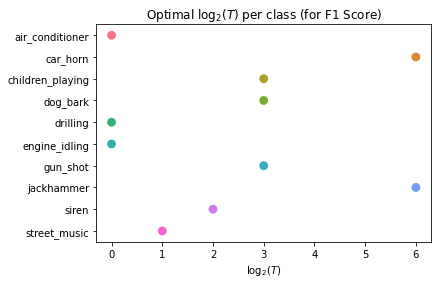

In [6]:
f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='dry']\
                 [sample_df['eval_dataset']=='dry']
f1_single_df = f1_df[f1_df['num_slices']==1]
f1_classgroup = f1_single_df.groupby('class')
best_single_slice = {}
for key, item in f1_classgroup:
    mean_series = f1_classgroup.get_group(key).groupby('slices').mean()
    max_slice = mean_series['value'].argmax()
    best_single_slice[key] = max_slice

classes = ['air_conditioner', 'car_horn', 'children_playing',\
           'dog_bark', 'drilling', 'engine_idling', 'gun_shot',\
           'jackhammer', 'siren', 'street_music']

best_slices = [best_single_slice[c] for c in classes]
sns.pointplot(x=best_slices, y=classes, join=False, palette='husl')
plt.title(r"Optimal $\log_2(T)$ per class (for F1 Score)")
plt.xlabel(r"$\log_2(T)$")

<ipython-input-7-6e755eca3d10>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\


Text(0.5, 1.0, 'Overall F1 Scores Across Models (dry)')

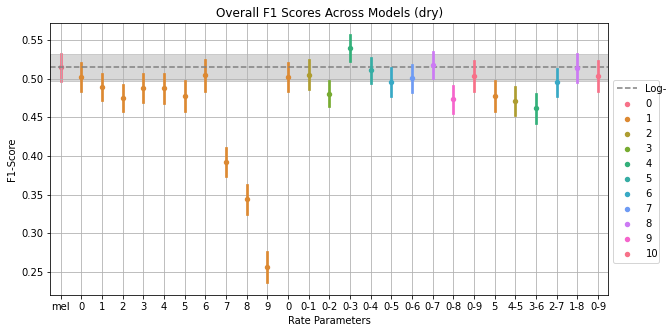

In [7]:
f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='dry']\
                 [sample_df['eval_dataset']=='dry']\
                 [sample_df['class']=='overall']
f1_single_df = f1_df[f1_df['num_slices']==1]
f1_increasing_df = f1_df[f1_df['slices'].isin(slices_multiple)]
f1_midout_df = f1_df[f1_df['slices'].isin(slices_midout)]
f1_mel_df = f1_df[f1_df['num_slices']==0]

slices_all = ['mel'] + slices_single + slices_multiple + slices_midout
slice_labels = []
for slices in slices_all:
    if len(slices)==1 or slices=='mel':
        slice_labels.append(slices)
    else:
        slice_labels.append('{}-{}'.format(min(slices), max(slices)))

plt.figure(figsize=(10,5))
ax = sns.pointplot(x="slices", y="value", data=f1_df, palette=sns.color_palette('husl', 10), hue='num_slices', order=slices_all, ci='sd', join=False, markers='.')

logmel_mean = f1_mel_df['value'].mean()
logmel_std = f1_mel_df['value'].std()
ax.axhline(logmel_mean, color='grey', linestyle='--', label='Log-Mel-Spectrogram')
std_max = logmel_mean + logmel_std
std_min = logmel_mean - logmel_std
ax.axhspan(std_max, std_min, color='grey', alpha=.3)

ax.legend(bbox_to_anchor=(1,.1, .1,2), mode='expand', loc='lower left')
ax.set_xticklabels(slice_labels)
ax.set_xlabel('Rate Parameters')
ax.set_ylabel('F1-Score')
plt.grid()
plt.title('Overall F1 Scores Across Models (dry)')

<ipython-input-8-e52430c1a13f>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\


Text(0.5, 1.0, 'Overall F1 Scores Across Models (w/reverb)')

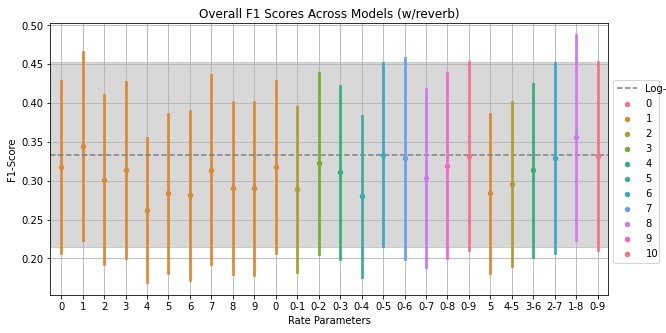

In [8]:
f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='realreverb']\
                 [sample_df['eval_dataset'].isin(real_reverb_set)]\
                 [sample_df['class']=='overall']
f1_single_df = f1_df[f1_df['num_slices']==1]
f1_increasing_df = f1_df[f1_df['slices'].isin(slices_multiple)]
f1_midout_df = f1_df[f1_df['slices'].isin(slices_midout)]
f1_mel_df = f1_df[f1_df['num_slices']==0]

slices_all = slices_single + slices_multiple + slices_midout
slice_labels = []
for slices in slices_all:
    if len(slices)==1:
        slice_labels.append(slices)
    else:
        slice_labels.append('{}-{}'.format(min(slices), max(slices)))

plt.figure(figsize=(10,5))
ax = sns.pointplot(x="slices", y="value", data=f1_df, palette=sns.color_palette('husl', 10), hue='num_slices', order=slices_all, ci='sd', join=False, markers='.')

logmel_mean = f1_mel_df['value'].mean()
logmel_std = f1_mel_df['value'].std()
ax.axhline(logmel_mean, color='grey', linestyle='--', label='Log-Mel-Spectrogram')
std_max = logmel_mean + logmel_std
std_min = logmel_mean - logmel_std
ax.axhspan(std_max, std_min, color='grey', alpha=.3)

ax.legend(bbox_to_anchor=(1,.1, .1,2), mode='expand', loc='lower left')
ax.set_xticklabels(slice_labels)
ax.set_xlabel('Rate Parameters')
ax.set_ylabel('F1-Score')
plt.grid()
plt.title('Overall F1 Scores Across Models (w/reverb)')

<ipython-input-9-37c64443674c>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\
<ipython-input-9-37c64443674c>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_overall_df = f1_df[f1_df['class']=='overall']\


slices
0123456789    0.331757
Name: value, dtype: float64
0.33175737356135326
0123456789
0.12157778142945966


<ipython-input-9-37c64443674c>:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_optmulti_df =  sample_df[sample_df['metric']=='f_measure']\
<ipython-input-9-37c64443674c>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\
/scratch/ci411/.conda/envs/py3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


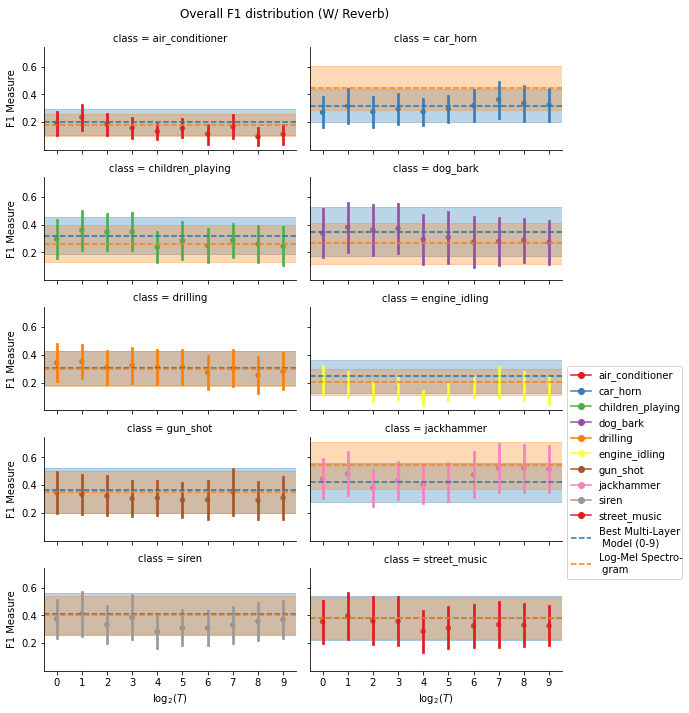

In [9]:
f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='realreverb']\
                 [sample_df['eval_dataset'].isin(real_reverb_set)]\

f1_single_df = f1_df[f1_df['num_slices']==1]
f1_increasing_df = f1_df[f1_df['slices'].isin(slices_multiple)]
f1_midout_df = f1_df[f1_df['slices'].isin(slices_midout)]
f1_logmel_df = f1_df[f1_df['num_slices']==0]

sample_logmel_df = sample_df[sample_df['slices']=='mel']

f1_overall_df = f1_df[f1_df['class']=='overall']\
                     [f1_df['slices'].isin(slices_midout)]\
                     [f1_df['slices'].isin(slices_multiple)]

f1_overall_gb = f1_overall_df.groupby(['slices'])

means = f1_overall_gb['value'].mean()
stds = f1_overall_gb['value'].std()
max_multi_val = means.max()
max_multi_slice = means[means==max_multi_val].index.tolist()[0]
max_multi_std = stds[max_multi_slice]
print(means)
print(max_multi_val)
print(max_multi_slice)
print(max_multi_std)



#dataframe for overall optimal multilayer model
f1_optmulti_df =  sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='realreverb']\
                 [sample_df['eval_dataset'].isin(real_reverb_set)]\
                 [sample_df['slices']==max_multi_slice]

f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='realreverb']\
                 [sample_df['eval_dataset'].isin(real_reverb_set)]
f1_single_df = f1_df[f1_df['num_slices']==1]


class_order = URBANSED_CLASSES
#filter out "overall"
sub_df = f1_single_df[f1_single_df['class'].isin(class_order)]

#generate colors
colors = sns.color_palette(palette='Set1', n_colors=len(class_order))

#build facet_grid
g = sns.FacetGrid(sub_df, col="class", col_order=class_order,col_wrap=2, aspect=2,\
                  height=2, hue='class', palette='Set1', legend_out=True)

#measure mean and best model by average performance
means_df = f1_single_df.groupby(['class'])
max_coords = {}
for name, group in means_df:
    means = group.groupby('slices').mean()
    stds = group.groupby('slices').std()
    max_val = means['value'].max()
    max_slice = means[means['value']==max_val].index.tolist()[0]
    max_coords[name] = (max_slice, max_val)
    

#compute mean and std of optimal model on each class
multiopt_df = f1_optmulti_df.groupby(['class'])
max_opt_multi_coords = {}
for name, group in multiopt_df:
    means = group.groupby('slices').mean()
    stds = group.groupby('slices').std()
    opt_multi_val = means.iloc[0]['value']
    opt_multi_std = stds.iloc[0]['value']
    max_opt_multi_coords[name] = (opt_multi_val, opt_multi_std)
    
#compute mean and std of logmel on each class
logmel_classes_gb = f1_logmel_df.groupby(['class'])
max_logmel_coords = {}
for name, group in logmel_classes_gb:
    mean = group['value'].mean()
    std = group['value'].std()
    max_logmel_coords[name] = (mean, std)

#pointplots
g.map(sns.pointplot, "slices", "value", ci='sd', join=False, markers='.')

#plot maximal values/model params
for i, ax in enumerate(g.axes):
    key = class_order[i]
    x, y = max_coords[key]

    opt_multi_val, opt_multi_std =  max_opt_multi_coords[key]
    ax.axhline(opt_multi_val, color='C0', linestyle='--')
    std_max = opt_multi_val + opt_multi_std
    std_min = opt_multi_val - opt_multi_std
    ax.axhspan(std_max, std_min, color='C0', alpha=.3)
    
    logmel_mean, logmel_std =  max_logmel_coords[key]
    ax.axhline(logmel_mean, color='C1', linestyle='--')
    std_max = logmel_mean + logmel_std
    std_min = logmel_mean - logmel_std
    ax.axhspan(std_max, std_min, color='C1', alpha=.3)
    
    if i%2 == 0:
        ax.set_ylabel('F1 Measure')
    if i>7:
        ax.set_xlabel(r'$\log_2 (T)$')
        

#add title   
plt.subplots_adjust(top=0.925)
#g.set(ylim=(0,.85))
g.fig.suptitle('Overall F1 distribution (W/ Reverb)')

#customize legend
legend_elements = [Line2D([0], [0], marker='o', color=colors[i], label=class_order[i])\
                  for i in range(len(class_order))]
legend_elements.append(Line2D([0], [0], color='C0', linestyle='--', label="Best Multi-Layer\n Model ({}-{})".format(min(max_multi_slice), max(max_multi_slice))))
legend_elements.append(Line2D([0], [0], color='C1', linestyle='--', label="Log-Mel Spectro-\n gram"))



plt.legend(handles=legend_elements, bbox_to_anchor=(1,1,.5,2), mode='expand', loc='upper left')

In [28]:
f1_df.sample(10)

,version,training_set,slices,eval_dataset,model,class/metric,value,metric,class,modelset,num_slices
3258655,dry_01_1014,dry,01,dry,cnn_l3_strong,street_music_f1,0.556452,f_measure,street_music,1014,2
1762861,dry_01234567_1014,dry,01234567,dry,cnn_l3_strong,drilling_f1,0.607843,f_measure,drilling,1014,8
2358462,dry_6_1014,dry,6,dry,cnn_l3_strong,gun_shot_f1,0.524823,f_measure,gun_shot,1014,1
3255663,dry_5_1014,dry,5,dry,cnn_l3_strong,street_music_f1,0.497696,f_measure,street_music,1014,1
2366431,dry_1_1014,dry,1,dry,cnn_l3_strong,gun_shot_f1,0.529032,f_measure,gun_shot,1014,1
1702842,dry_012345_1014,dry,012345,dry,cnn_l3_strong,drilling_f1,0.497354,f_measure,drilling,1014,6
1441855,dry_8_1014,dry,8,dry,cnn_l3_strong,dog_bark_f1,0.518797,f_measure,dog_bark,1014,1
2670629,dry_8_1014,dry,8,dry,cnn_l3_strong,jackhammer_f1,0.609524,f_measure,jackhammer,1014,1
1406812,dry_012345678_1014,dry,012345678,dry,cnn_l3_strong,dog_bark_f1,0.441315,f_measure,dog_bark,1014,9
1439272,dry_12345678_1014,dry,12345678,dry,cnn_l3_strong,dog_bark_f1,0.407767,f_measure,dog_bark,1014,8


<ipython-input-29-85fc90baf287>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\
<ipython-input-29-85fc90baf287>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_overall_df = f1_df[f1_df['class']=='overall']\


slices
0123456789    0.503711
Name: value, dtype: float64
slices
0123456789    0.503711
Name: value, dtype: float64
0.5037108741492389
0123456789
0.019610675374770327


<ipython-input-29-85fc90baf287>:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_optmulti_df =  sample_df[sample_df['metric']=='f_measure']\
<ipython-input-29-85fc90baf287>:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\
/scratch/ci411/.conda/envs/py3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


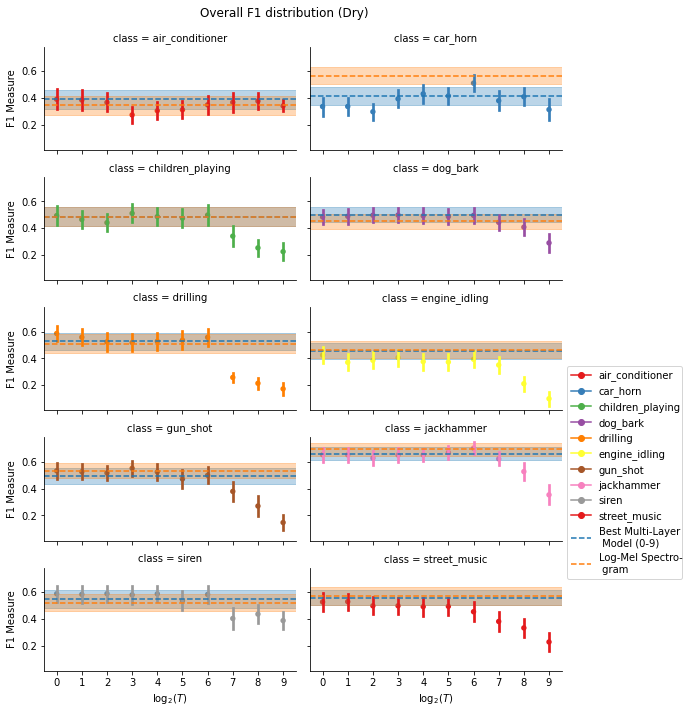

In [29]:
f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='dry']\
                 [sample_df['eval_dataset']=='dry']\

f1_single_df = f1_df[f1_df['num_slices']==1]
f1_increasing_df = f1_df[f1_df['slices'].isin(slices_multiple)]
f1_midout_df = f1_df[f1_df['slices'].isin(slices_midout)]
f1_logmel_df = f1_df[f1_df['num_slices']==0]

sample_logmel_df = sample_df[sample_df['slices']=='mel']

f1_overall_df = f1_df[f1_df['class']=='overall']\
                     [f1_df['slices'].isin(slices_midout)]\
                     [f1_df['slices'].isin(slices_multiple)]

f1_overall_gb = f1_overall_df.groupby(['slices'])

means = f1_overall_gb['value'].mean()
stds = f1_overall_gb['value'].std()
max_multi_val = means.max()
max_multi_slice = means[means==max_multi_val].index.tolist()[0]
max_multi_std = stds[max_multi_slice]
print(means[means==max_multi_val])
print(means)
print(max_multi_val)
print(max_multi_slice)
print(max_multi_std)



#dataframe for overall optimal multilayer model
f1_optmulti_df =  sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='dry']\
                 [sample_df['eval_dataset']=='dry']\
                 [sample_df['slices']==max_multi_slice]

f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='dry']\
                 [sample_df['eval_dataset']=='dry']
f1_single_df = f1_df[f1_df['num_slices']==1]


class_order = URBANSED_CLASSES
#filter out "overall"
sub_df = f1_single_df[f1_single_df['class'].isin(class_order)]

#generate colors
colors = sns.color_palette(palette='Set1', n_colors=len(class_order))

#build facet_grid
g = sns.FacetGrid(sub_df, col="class", col_order=class_order,col_wrap=2, aspect=2,\
                  height=2, hue='class', palette='Set1', legend_out=True)

#measure mean and best model by average performance
means_df = f1_single_df.groupby(['class'])
max_coords = {}
for name, group in means_df:
    means = group.groupby('slices').mean()
    stds = group.groupby('slices').std()
    max_val = means['value'].max()
    max_slice = means[means['value']==max_val].index.tolist()[0]
    max_coords[name] = (max_slice, max_val)
    

#compute mean and std of optimal model on each class
multiopt_df = f1_optmulti_df.groupby(['class'])
max_opt_multi_coords = {}
for name, group in multiopt_df:
    means = group.groupby('slices').mean()
    stds = group.groupby('slices').std()
    opt_multi_val = means.iloc[0]['value']
    opt_multi_std = stds.iloc[0]['value']
    max_opt_multi_coords[name] = (opt_multi_val, opt_multi_std)
    
#compute mean and std of logmel on each class
logmel_classes_gb = f1_logmel_df.groupby(['class'])
max_logmel_coords = {}
for name, group in logmel_classes_gb:
    mean = group['value'].mean()
    std = group['value'].std()
    max_logmel_coords[name] = (mean, std)

#pointplots
g.map(sns.pointplot, "slices", "value", ci='sd', join=False, markers='.')

#plot maximal values/model params
for i, ax in enumerate(g.axes):
    key = class_order[i]
    x, y = max_coords[key]

    opt_multi_val, opt_multi_std =  max_opt_multi_coords[key]
    ax.axhline(opt_multi_val, color='C0', linestyle='--')
    std_max = opt_multi_val + opt_multi_std
    std_min = opt_multi_val - opt_multi_std
    ax.axhspan(std_max, std_min, color='C0', alpha=.3)
    
    logmel_mean, logmel_std =  max_logmel_coords[key]
    ax.axhline(logmel_mean, color='C1', linestyle='--')
    std_max = logmel_mean + logmel_std
    std_min = logmel_mean - logmel_std
    ax.axhspan(std_max, std_min, color='C1', alpha=.3)
    
    if i%2 == 0:
        ax.set_ylabel('F1 Measure')
    if i>7:
        ax.set_xlabel(r'$\log_2 (T)$')
        

#add title   
plt.subplots_adjust(top=0.925)
#g.set(ylim=(0,.85))
g.fig.suptitle('Overall F1 distribution (Dry)')

#customize legend
legend_elements = [Line2D([0], [0], marker='o', color=colors[i], label=class_order[i])\
                  for i in range(len(class_order))]
legend_elements.append(Line2D([0], [0], color='C0', linestyle='--', label="Best Multi-Layer\n Model ({}-{})".format(min(max_multi_slice), max(max_multi_slice))))
legend_elements.append(Line2D([0], [0], color='C1', linestyle='--', label="Log-Mel Spectro-\n gram"))



plt.legend(handles=legend_elements, bbox_to_anchor=(1,1,.5,2), mode='expand', loc='upper left')

In [26]:
#declare paths
audio_path = "/beegfs/ci411/pcen/reverb_pitch_URBAN-SED/audio"
annotations_path = "/beegfs/ci411/pcen/reverb_pitch_URBAN-SED/annotations"

pcen_path = "/beegfs/ci411/pcen/features_807/pcen"
mel_path = "/beegfs/ci411/pcen/features_807/mel"
models_path = '/beegfs/ci411/pcen/models/models_1014'


#select example file
test_file = 'soundscape_train_bimodal1798_tunnel'
semitone = '0'

#declare audio/feature paths of example
test_audio = os.path.join(audio_path, 'train', test_file + '_{}.wav'.format(semitone))
test_annotations = os.path.join(annotations_path, 'train', test_file + '_{}.jams'.format(semitone))

test_pcen = os.path.join(pcen_path,'URBAN-SED_tunnel', 'train', test_file +'_{}.h5'.format(semitone))
test_mel = os.path.join(mel_path, 'URBAN-SED_tunnel', 'train', test_file +'_{}.h5'.format(semitone))

#declare specific example models
pcen_model_name = 'wet_0123456789_model1014'
pcen_model_path = os.path.join(models_path, pcen_model_name, 'model.yaml')
pcen_model_weights = os.path.join(models_path, pcen_model_name, 'model.h5')
mel_model_name = 'wet_mel_model1014'
mel_model_path = os.path.join(models_path, mel_model_name, 'model.yaml')
mel_model_weights = os.path.join(models_path, mel_model_name, 'model.h5')

#load features/labels
pcen_all = load_h5(test_pcen)
mel_all = load_h5(test_mel)

#ensure labels are identical
pcen_labels = pcen_all['dynamic/tags']
mel_labels = mel_all['dynamic/tags']
assert (pcen_labels==mel_labels).all()

#store labels
true_tags = max_pool(pcen_labels)[0]

#store features
pcen_data = pcen_all['PCEN/mag'][0,:,:,2].T
mel_data = mel_all['Mel/mag'][0,:,:,0].T

#import models
with open(pcen_model_path, 'r') as pcen_yaml_file:
    pcen_model_yaml = pcen_yaml_file.read()
    pcen_model = model_from_yaml(pcen_model_yaml, custom_objects={'SqueezeLayer':SqueezeLayer})
    pcen_model.load_weights(pcen_model_weights)
with open(mel_model_path, 'r') as mel_yaml_file:
    mel_model_yaml = mel_yaml_file.read()
    mel_model = model_from_yaml(mel_model_yaml, custom_objects={'SqueezeLayer':SqueezeLayer})
    mel_model.load_weights(mel_model_weights)
    
#extract predictions
pcen_preds = pcen_model.predict(pcen_all['PCEN/mag'])[0] #note slices are tricky
mel_preds = mel_model.predict(mel_all['Mel/mag'])[0]



FileNotFoundError: [Errno 2] No such file or directory: '/beegfs/ci411/pcen/models/models_1014/wet_0123456789_model1014/model.yaml'

In [ ]:
for key in list(pcen_all.keys()):
    if 'mag' in key:
        print(key)

In [ ]:
fig, ax = plt.subplots(nrows=5, figsize=(14,12), sharex=True)
xlim=(0,10)

#plot tags
cf_tags = specshow(true_tags.T, ax=ax[0], x_axis='time', sr= 22050, hop_length=1024*16)
ax[0].label_outer()
ax[0].set_xlim(xlim)
ax[0].set_yticks(np.arange(len(URBANSED_CLASSES))+.5)
ax[0].set_yticklabels(labels=URBANSED_CLASSES)


#plot predictions
cf_pcen_pred = specshow(pcen_preds.T, ax=ax[1], x_axis='time', sr= 22050, hop_length=1024*16)#ax[1].pcolormesh(, vmin=0, vmax=1)
ax[1].label_outer()
ax[1].set_xlim(xlim)
ax[1].set_yticks(np.arange(len(URBANSED_CLASSES))+.5)
ax[1].set_yticklabels(labels=URBANSED_CLASSES)
ax[1].set_title(pcen_model_name + " predictions")

cf_mel_pred = specshow(mel_preds.T, ax=ax[2], x_axis='time', sr= 22050, hop_length=1024*16)#ax[2].pcolormesh(mel_preds.T, vmin=0, vmax=1)
ax[2].label_outer()
ax[2].set_xlim(xlim)
ax[2].set_yticks(np.arange(len(URBANSED_CLASSES))+.5)
ax[2].set_yticklabels(labels=URBANSED_CLASSES)
ax[2].set_title(mel_model_name + " predictions")


#plot audio
cf_pcen = specshow(pcen_data, ax=ax[3], x_axis='time', sr= 22050, hop_length=1024)#ax[3].pcolormesh(pcen_data, vmin=0, vmax=1)
ax[3].label_outer()
ax[3].set_xlim(xlim)
ax[3].set_yticks([])
ax[3].set_title('PCEN Spectrogram (One layer)')

cf_mel = specshow(mel_data, ax=ax[4], x_axis='time', sr= 22050, hop_length=1024)
ax[4].label_outer()
ax[4].set_xlim(xlim)
ax[4].set_yticks([])
ax[4].set_title("Log-Scaled Mel-Spectrogram")

Audio(test_audio)

In [24]:
from librosa.display import specshow
from pcen_t.utils import *
from keras.models import model_from_yaml

def plot_preds(model_path, feature_path, label_ax=None, spec_ax=None, slices=[0], plot_slice=0):
    #load models
    with open(os.path.join(model_path,'model.yaml'), 'r') as model_yaml:
        model = model_from_yaml(model_yaml.read(), custom_objects={'SqueezeLayer':SqueezeLayer})
        model.load_weights(os.path.join(model_path,'model.h5'))
    
    #load features
    all_data = load_h5(feature_path)
    data_key = ''
    
    #extract key for features
    for key in list(all_data.keys()):
        if 'mag' in key:
            data_key = key
    data = all_data[data_key]
    
    #extract/pool labels
    labels = max_pool(all_data['dynamic/tags'])[0]

    #compute predictions
    preds = model.predict(data[:,:,:,slices])[0]
    
    #plot results
    if label_ax is not None:
        specshow(preds.T, ax=label_ax, sr=22050, hop_length=1024*16)
        label_ax.set_yticks(np.arange(len(URBANSED_CLASSES))+.5)
        label_ax.set_yticklabels(labels=URBANSED_CLASSES)
        
    if spec_ax is not None:
        specshow(data[0,:,:,plot_slice].T, ax=spec_ax, x_axis='time', sr=22050, hop_length=1024)

FileNotFoundError: [Errno 2] No such file or directory: '/beegfs/ci411/pcen/models/models_1014/wet_0123456789_model807/model.yaml'

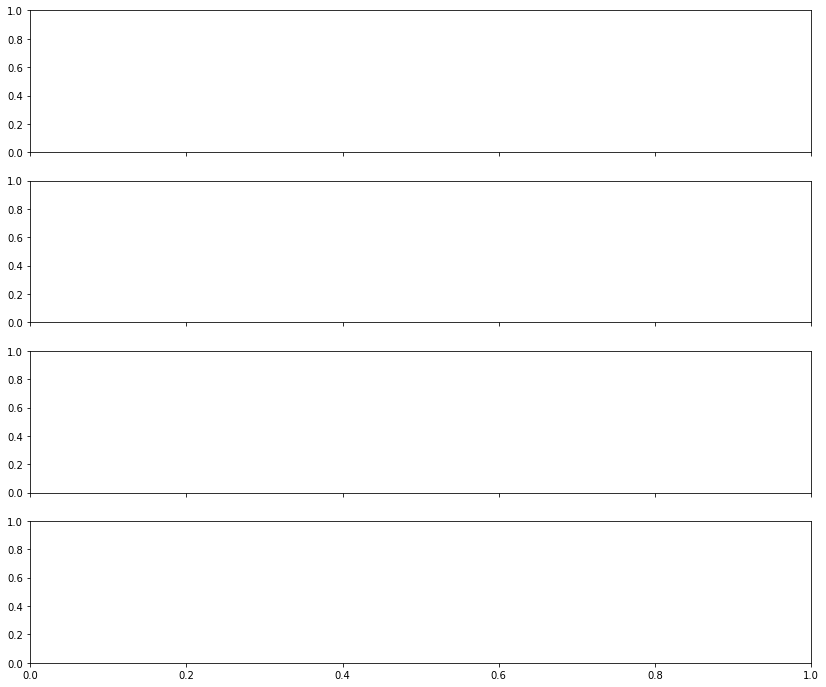

In [25]:
fig, ax = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

model_test_folder = os.path.join(models_path, pcen_model_name)
feature_test = os.path.join(pcen_path,'URBAN-SED_tunnel', 'train', test_file +'_{}.h5'.format(semitone))
plot_preds(model_test_folder, feature_test, label_ax=ax[0], spec_ax=ax[1], plot_slice=4, slices=np.arange(10))

model_test_folder = os.path.join(models_path, mel_model_name)
feature_test = os.path.join(mel_path,'URBAN-SED_tunnel', 'train', test_file +'_{}.h5'.format(semitone))
plot_preds(model_test_folder, feature_test, label_ax=ax[2], spec_ax=ax[3])

for axi in ax:
    axi.label_outer()
    axi.set_xlim(xlim)

In [16]:
overall_f1_df = sample_df[sample_df['class/metric']=='overall_f1']

In [17]:
wet_overall_f1_df = overall_f1_df[overall_f1_df['training_set']=='wet']\
                                 [overall_f1_df['eval_dataset']=='wet']

<ipython-input-17-081aca2cf099>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wet_overall_f1_df = overall_f1_df[overall_f1_df['training_set']=='wet']\


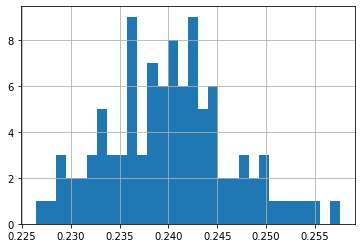

In [18]:
wof1_5_df = wet_overall_f1_df[wet_overall_f1_df['slices']=='5']
wof1_5_df['value'].hist(bins=30)

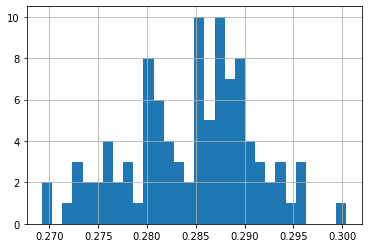

In [19]:
wof1_0_9_df = wet_overall_f1_df[wet_overall_f1_df['slices']=='0123456789']
wof1_0_9_df['value'].hist(bins=30)

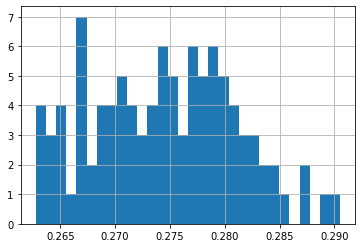

In [20]:
wof1_mel_df = wet_overall_f1_df[wet_overall_f1_df['slices']=='mel']
wof1_mel_df['value'].hist(bins=30)

<ipython-input-21-4097545901cf>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dry_overall_df = sample_df[sample_df['training_set']=='dry']\
<ipython-input-21-4097545901cf>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  do_mel_df = dry_overall_df[dry_overall_df['slices']=='mel']\


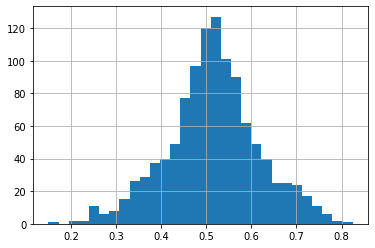

In [21]:
dry_overall_df = sample_df[sample_df['training_set']=='dry']\
                                 [sample_df['eval_dataset']=='dry']

do_mel_df = dry_overall_df[dry_overall_df['slices']=='mel']\
                          [dry_overall_df['metric']=='f_measure']

do_mel_df['value'].hist(bins=30)

In [22]:
do_mel_df['value'].mean()

0.5144227161413385